In [ ]:
#pip install fastbook

In [ ]:
from fastai.vision.all import *
import ipywidgets as widgets

path= untar_data(URLs.MNIST_SAMPLE)
threes= (path/'train'/'3').ls().sorted()
sevens= (path/'train'/'7').ls().sorted()

three_tensors= [tensor(Image.open(o)) for o in threes]
seven_tensors= [tensor(Image.open(o)) for o in sevens]

stacked_threes= torch.stack(three_tensors).float()/255
stacked_sevens= torch.stack(seven_tensors).float()/255

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

valid_3_tens= torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens= torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])

valid_3_tens= valid_3_tens.float()/255
valid_7_tens= valid_7_tens.float()/255

def sigmoid(x): return 1/(1+torch.exp(-x))

def mnist_loss(predictions, targets):
  predictions= predictions.sigmoid()
  return torch.where(targets== 1, 1-predictions, predictions).mean()

train_x= torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y= tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

dset= list(zip(train_x, train_y))

valid_x= torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y= tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

valid_dset= list(zip(valid_x, valid_y))

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

def linear1(xb): return xb@weights + bias

weights= init_params((28*28, 1))
bias= init_params(1)

dl= DataLoader(dset, batch_size= 256)
xb, yb= first(dl)

valid_dl= DataLoader(valid_dset, batch_size=256)

batch= train_x[:4]

preds= linear1(batch)

loss= mnist_loss(preds, train_y[:4])

loss.backward()

def calc_grad(xb, yb, model):
  preds= model(xb)
  loss= mnist_loss(preds, yb)
  loss.backward()

calc_grad(batch, train_y[:4], linear1)

weights.grad.zero_()
bias.grad.zero_();

def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()

def batch_accuracy(xb, yb):
  preds= xb.sigmoid()
  correct= (preds>0.5) == yb
  return correct.float().mean()

def validate_epoch(model):
  accs= [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

lr= 1.
params= weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7259

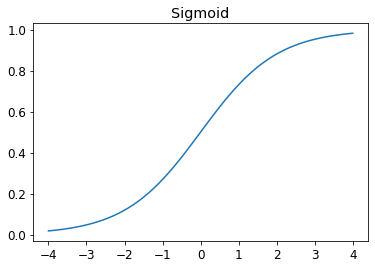

In [ ]:
from fastbook import *
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

# 4.6.1 옵티마이저 만들기
### 가장 먼저 시도할 일
#### linear1 함수를 파이토치의 nn.Linear 모듈로 대체하는 것.
##### * '모듈': 파이토치의 nn.Module 클래스를 상속받은 클래스 객체를 의미.
### nn.Linear는
##### * 앞서 만든 init_params 및 linear의 작동을 하나로 수행한다.
##### ** 단일 클래스 내에 '가중치'와 '편향' 모두가 저장된다.


In [ ]:
linear_model = nn.Linear(28*28, 1)

### 파라미터 목록은 parameters 메소드로 접근할 수 있다.

In [ ]:
w, b= linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

##### 이 파라미터 정보는 옵티마이저를 정의하는데 활용할 수 있다.

In [ ]:
class BasicOptim:
  def __init__(self, params, lr): self.params, self.lr= list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad= None

In [ ]:
opt= BasicOptim(linear_model.parameters(), lr)

### 이제, 학습 루프를 다음처럼 간소화 할 수 있다.

In [ ]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

##### 검증용 데이터셋의 정호가도를 구하는 validate_epoch는 구현 내용을 바꾸지 않아도 잘 작동한다.

In [ ]:
validate_epoch(linear_model)

0.4884

### 이번에는, train_model이라는 함수를 정의하고, 그 안에 학습 루프 및 검증용 데이터셋의 정확도를 구하는 과정을 모두 포함해보겠다.
##### 이로써 좀 더 추상적인 관점에서 전체 과정을 간단히 바라볼 수 있다.

In [ ]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end='')

### 결과가 앞 절에서와 같음을 확인.

In [ ]:
train_model(linear_model, 20)

0.49320.66550.8550.91650.93650.95020.95650.96330.96630.96720.97020.97210.97360.97510.9760.9770.97750.9780.9780.9785

### fastai는 SGD클래스를 제공한다.
##### 기본으로 설정된 SGD 클래스는 방금 만든 BasicOptim 클래스와 정호가히 가튼 방식으로 작동한다.

In [ ]:
linear_model= nn.Linear(28*28, 1)
opt= SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.49320.82470.84620.9140.93550.94720.95650.96240.96580.96680.97020.97210.97360.97460.9760.9760.97750.97850.97850.9785

### fastai는 
#### **train_model** 함수 대신 사용할 수 있는 **Learner.fit** 도 제공한다.
##### Learner.fit을 사용하려면, 우선 **Learner**를 생성해야 한다. 그리고 Learner를 생성하려면 DataLoaders를 만들어야 한다.
##### DataLoaders는 학습용과 검증용 DataLoader에서 쉽게 만들 수 있다.

In [ ]:
dls= DataLoaders(dl, valid_dl)

### cnn_learner(현 vision_learner) 같은 편리성 함수를 사용하지 않고 Learner를 생성하려면 
#### 이 장에서 만든 모든 요소를 Learner의 생성 인자로 전달해야 한다.
##### 즉, 기본적으로 'DataLoaders', '모델', '최적화 함수'(모델의 파라미터가 전달됨), '손실함수'가 지정되어야 하며, 추가로 출력을 원하는 '평가지표'도 함께 작성할 수 있다.

In [ ]:
learn= Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
               loss_func=mnist_loss, metrics= batch_accuracy)

In [ ]:
# 이제 Learner 객체에 포함된 fit 메소드를 호출할 수 있다.
learn.fit(10, lr= lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637093,0.502737,0.495584,00:00
1,0.369545,0.272814,0.745339,00:00
2,0.141560,0.154224,0.861629,00:00
3,0.065627,0.097380,0.918057,00:00
4,0.037399,0.073108,0.936703,00:00
5,0.026166,0.059512,0.948970,00:00
6,0.021419,0.050921,0.957311,00:00
7,0.019218,0.045126,0.963199,00:00
8,0.018039,0.041000,0.966143,00:00
9,0.017289,0.037925,0.967125,00:00


# 4.7 비선형성 추가
### 이전까지의 내용들은 **'선형 분류 모델'**에 대한 내용들이었다.
#### 더 복잡한 일을 다루려면, 분류 모델을 **더 복잡하게** 바꿔줘야 한다.
##### 두 선형 분류 모델(계층) 사이에 **'비선형'**을 추가하면 된다.
### 다음은 **간단한 신경망**을 정의한 코드이다.

In [ ]:
#def simple_net(xb):
#  res= xb@w1 + b1
#  res= res.max(tensor(0.0))
#  res= res@w2 + b2
#  return res

### 위에 작성한 simple_net은 '두 선형성'과 그 '사이에' 존재하는 'max 함수'만으로 구성된다.
##### w1, w2는 가중치 '텐서'
##### b1, b2는 편향 '텐서'이다.
##### 이런 파라미터는 앞 절에서처럼 임의로 초기화된다.

In [ ]:
w1= init_params((28*28, 30))
b1= init_params(30)
w2= init_params((30, 1))
b2= init_params(1)

### w1에는 출력 활성이 30개 있다는 점이 중요하다.
##### * w2는 w1과 **맞물릴 수 있게** 입력 활성이 30개여야 한다.

### res.max(tensor(0.0))함수는 **'ReLU 함수'**라고도 한다.
##### * 모든 음숫값을 0으로 교체한다.
##### ** 파이토치는 'F.relu'로 제공한다.

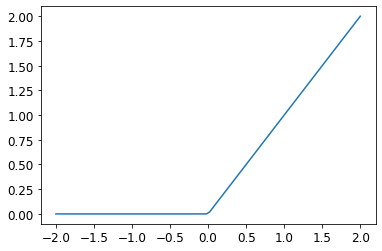

In [ ]:
plot_function(F.relu)

### w1, w2를 충분히 큰 행렬로 구성하고, 행렬의 올바른 값을 찾을 수만 있다면, 이 단순한 함수는 모든 계산 가능한 문제를 높은 정확도로 풀어낸다.
#### 수많은 짧은 선을 연결하면, 모든 구불구불한 함수를 추정할 수 있을 것이다. 이를 **"일반 근사 정리"**라고 한다.
##### 다음 코드는 여러 '계층'을 표현한다.

In [ ]:
simple_net= nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

### nn.Sequential(): 인자로 나열된 계층을 '순차적으로' 호출하는 모듈을 생성한다.
##### * nn.Linear(): "선형 계층"
##### ** nn.ReLU(): 비선형성 또는 "활성화 함수"

### nn.Sequential 또한 모듈이므로, 파라미터를 관리한다.
#### 따라서, nn.Sequential에 포함된 '모든' 모듈에 있는 **"파라미터 목록"**을 얻을 수 있다.

In [ ]:
learn= Learner(dls, simple_net, opt_func=SGD,
               loss_func= mnist_loss, metrics= batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.321553,0.398654,0.509323,00:00
1,0.148813,0.229344,0.803729,00:00
2,0.082180,0.115545,0.912169,00:00
3,0.053814,0.077860,0.941609,00:00
4,0.040673,0.060659,0.958292,00:00
5,0.033984,0.051013,0.963690,00:00
6,0.030156,0.044946,0.965162,00:00
7,0.027680,0.040815,0.967615,00:00
8,0.025901,0.037830,0.969578,00:00
9,0.024526,0.035563,0.970559,00:00


### 학습 과정은 learn.recorder에 기록된다.
##### learn.fit(): 피팅함수, pretrained 모델을 사용하지 않기 때문에 fine_tune 함수는 사용하지 않는다.

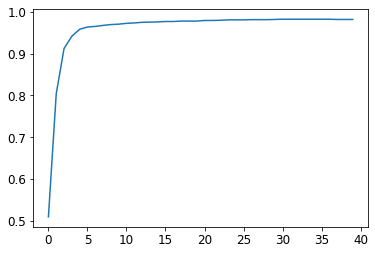

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

##### 마지막에 기록된 정확도를 출력할 수도 있음.

In [ ]:
learn.recorder.values[-1][2]

0.981844961643219

# 4.7.1 좀 더 깊은 모델

In [ ]:
dls= ImageDataLoaders.from_folder(path)
learn= vision_learner(dls, resnet18, pretrained= False,
                   loss_func= F.cross_entropy, metrics= accuracy)

learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.103369,0.015079,0.995584,01:59
